# Model comparison using distance metrics

In [1]:
import os
import pickle
import matplotlib
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# Pathing
data_folder = '/home/diego/data/dm/stac/results/JDM25_v6'
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if '.p' in f]

# Load list of dictionaries
data = [pickle.load(open(f, 'rb')) for f in files]


## Build a class for rat analysis

In [3]:
class rat_analysis():
    def __init__(self, snip):
        self.snip = snip
        self.mocap_names = [k for k in self.snip['_KEYPOINT_MODEL_PAIRS'].keys()]
        self.parts = {'arms': self._get_parts(['Arm', 'Elbow', 'Shoulder']),
         'legs': self._get_parts(['Shin', 'Knee', 'Hip']),
         'head': self._get_parts(['Head']),
         'body': self._get_parts(['Spine', 'Offset']),
         'total': self.mocap_names
        }
        self._marker_ids = {}
        for marker_id, val in enumerate(self.mocap_names):
            self._marker_ids[val] = marker_id*3 + np.array([0, 1, 2])
        self.kp_data = self.snip['kp_data']
        self.walker_body_sites = []
        for sitepos in self.snip['walker_body_sites']:
            self.walker_body_sites.append(sitepos.flatten())
        self.walker_body_sites = np.stack(self.walker_body_sites, axis=1).T  
        self.qpos = self.snip['qpos']
        
    def _get_parts(self, partnames):
        return [name for name in self.mocap_names if any(part in name for part in partnames)]
    
    def p_ids(self, parts):
        # If its a string, check to see if it is a common partname,
        # otherwise just turn it into a list,
        if isinstance(parts, str):
            if parts in self.parts.keys():
                parts = self.parts[parts]
            else:
                parts = [parts]
        
        # Build a logical array for easy indexing
        ids = np.zeros(len(self.mocap_names)*3, dtype='bool')
        for part in parts:
            if part in self._marker_ids.keys():
                ids[self._marker_ids[part]] = True
        return ids
    
rat = rat_analysis(data[0])
assert all(rat.p_ids('arms') == rat.p_ids(rat.parts['arms']))   
assert not any(rat.p_ids('arms') & rat.p_ids('legs'))        

## Make an analysis object for each snippet

In [4]:
rats = [rat_analysis(snip) for snip in data]

## Calculate the distances between each marker and its corresponding representation in the walker body after stac optimization

In [5]:
def get_distances(rat, parts):
    # Calculate the squared errors
    ids = rat.p_ids(parts)
    gt = rat.kp_data[:, ids]
    est = rat.walker_body_sites[:, ids]
    delta = (gt - est)**2
    
    # Find the distances for each marker
    n_dims = np.sum(ids)
    n_markers = int(n_dims/3)
    distances = np.zeros((delta.shape[0], n_markers))
    for i in range(n_markers):
        distances[:, i] = np.sqrt(np.sum(delta[:, i*3 + np.array([0, 1, 2])], axis=1))
    return distances

# For each snippet, find the distances on an appendage-by-appendage basis
deltas = []
for rat in rats:
    result = {}
    for part in rat.parts.keys():
        result[part] = get_distances(rat, part)
        result['mean_' + part] = np.nanmean(np.nanmean(result[part], axis=0))
    deltas.append(result)

## Plot the 3d error distances for each part group

<IPython.core.display.Javascript object>


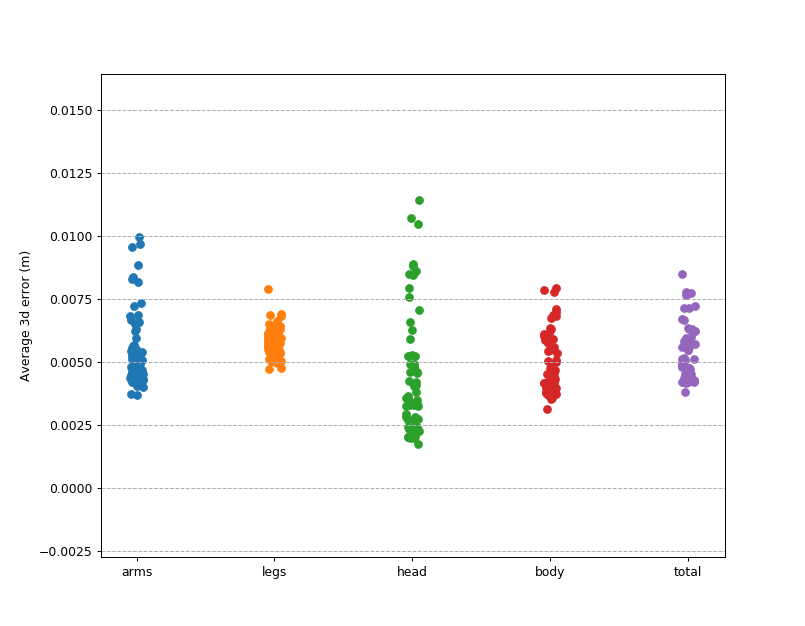

In [6]:
fig, ax = plt.subplots(figsize=(9,7))
plt.rcParams.update({'font.size': 14})
for i, part in enumerate(rats[0].parts.keys()):
    vals = [diff['mean_' + part] for diff in deltas]
    jitter = (np.random.rand(len(vals))-.5)*.1
    plt.scatter((i + jitter)*np.ones_like(vals), vals)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=rats[0].parts.keys())
plt.ylabel('Average 3d error (m)')
plt.grid(axis='y', linestyle='--')